In [1]:
import numpy as np
from scipy.ndimage import convolve

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale


In [11]:

def nudge_dataset(X, Y):
    """
    This produces a dataset 5 times bigger than the original one,
    by moving the 8x8 images in X around by 1px to left, right, down, up
    """
    direction_vectors = [
        [[0, 1, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [1, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 1], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 1, 0]],
    ]

    def shift(x, w):
        return convolve(x.reshape((8, 8)), mode="constant", weights=w).ravel()

    X = np.concatenate(
        [X] + [np.apply_along_axis(shift, 1, X, vector) for vector in direction_vectors]
    )
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y


X, Y = datasets.load_digits(return_X_y=True)
X = minmax_scale(X, feature_range=(0, 1))  # 0-1 scaling

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [52]:
import os
import numpy as np

n_categories = 10
n_variables = 121  # Number of variables in the dataset
mcm_filename_format = "train-images-unlabeled-{}_comms.dat"
data_filename_format = "train-images-unlabeled-{}.dat"
data_path = "../INPUT/data/"
communities_path = "../INPUT/MCMs/"
output_path = "../OUTPUT/"
data_size = 5423

# for k in range(n_categories):
X_train = np.empty((data_size*n_categories,n_variables))
for k in range(n_categories):
    im_path = os.path.join(data_path,data_filename_format.format(k))
    X_train[k*data_size:(k+1)*data_size, :] = np.genfromtxt(im_path,delimiter=1,dtype=int)
Y_train = np.repeat(np.arange(10),data_size)



In [53]:
# shape is (sample, image_size)
X_test = np.genfromtxt(os.path.join(data_path, "test-images-unlabeled-all-uniform.txt"),delimiter=1, dtype=int)
Y_test = np.loadtxt(os.path.join(data_path, "test-labels-uniform.txt"))


Data loaded.

In [54]:
from sklearn import linear_model
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline

logistic = linear_model.LogisticRegression(solver="newton-cg", tol=1)
rbm = BernoulliRBM(random_state=0, verbose=True)

rbm_features_classifier = Pipeline(steps=[("rbm", rbm), ("logistic", logistic)])

In [55]:
from sklearn.base import clone

# Hyper-parameters. These were set by cross-validation,
# using a GridSearchCV. Here we are not performing cross-validation to
# save time.
rbm.learning_rate = 0.06
rbm.n_iter = 10

# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 100
logistic.C = 6000

# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(X_train, Y_train)

# Training the Logistic regression classifier directly on the pixel
raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 100.0
raw_pixel_classifier.fit(X_train, Y_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -39.23, time = 1.88s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -36.18, time = 2.61s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -33.82, time = 2.66s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -32.43, time = 2.85s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -32.75, time = 2.67s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -32.02, time = 2.49s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -31.27, time = 2.29s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -30.97, time = 2.49s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -31.36, time = 3.97s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -31.04, time = 2.50s


LogisticRegression(C=100.0, solver='newton-cg', tol=1)

In [56]:
from sklearn import metrics

Y_pred = rbm_features_classifier.predict(X_test)
print(
    "Logistic regression using RBM features:\n%s\n"
    % (metrics.classification_report(Y_test, Y_pred))
)

Logistic regression using RBM features:
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       892
         1.0       0.98      0.98      0.98       892
         2.0       0.93      0.93      0.93       892
         3.0       0.90      0.91      0.90       892
         4.0       0.91      0.88      0.90       892
         5.0       0.91      0.90      0.91       892
         6.0       0.96      0.96      0.96       892
         7.0       0.94      0.91      0.92       892
         8.0       0.89      0.90      0.90       892
         9.0       0.86      0.88      0.87       892

    accuracy                           0.92      8920
   macro avg       0.92      0.92      0.92      8920
weighted avg       0.92      0.92      0.92      8920




ValueError: cannot reshape array of size 121 into shape (8,8)

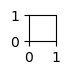

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((8, 8)), cmap=plt.cm.gray_r, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
plt.suptitle("100 components extracted by RBM", fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()